## TO DO ##

1.   Juntar las clases
2.   Hacer histogramas  de flujos, errores y SNR -> Me da una idea de lo que puedo eliminar
3.   Estimar la duración de los eventos. En volá sirve el peak.
4.   Determinar los puntos que son ruido y cómo eliminarlos.
5.   Features del host -> Edad y masa (usando las magnitudes g-r r-i) + Redshift 











# Classifying SNe

`Authors: Carolina Núñez, Vicente Pedreros, Antonio Vitalic`

The Dark Energy Science Collaboration released a new dataset with simulated light curves from LSST, including many classes of transient and persistent sources, including light curves and host information: [training set](https://portal.nersc.gov/cfs/lsst/DESC_TD_PUBLIC/ELASTICC/#trainingset)

In this project you are asked to build a classifier that can discriminate between the three classes of SNe: SNII (SNII-Templates, SNII-HostXT_V19 and SNII-NMF), SNIa (SNIa-91bg, SNIa-SALT2 and SNIax) and SNIbc (SNIb+HostXT_V19, SNIb-Templates, SNIc+HostXT_V19, SNIc-Templates, SNIcBL+HostXT_V19).
You can use metadata and light curve information.


Basic libraries are imported. Note that `Table` is used to transform the fits files to a pandas dataframe

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import os, fnmatch, glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Curating the data

The first thing to do is import the data. The function `to_df` will recieve the path to the first model of each class and return a dataframe. Note that the columns corresponding to the simulation data are dropped.

In [ ]:
head_filenames = fnmatch.filter(glob.glob('/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/*'), '*HEAD.FITS.gz')
# classes = [x.replace('_HEAD.FITS.gz', '').replace('/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados//', '') for x in head_filenames]


In [ ]:
head_filenames

['/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNII-NMF_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNII-Templates_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNII+HostXT_V19_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIb-Templates_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIb+HostXT_V19_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIc-Templates_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIc+HostXT_V19_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIcBL+HostXT_V19_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIa-SALT2_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIa-91bg_HEAD.FITS.gz',
 '/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/SNIax_HEAD.FITS.gz']

In [ ]:
def to_df(filename):
    """
    This function recieves a filename and will create a dataframe by using the HEAD's and PHOT's files.
    The columns corresponding to simulation information are droppped.

    Takes the data from all classes (asociated with the rows of .PHOT to the .HEAD)
    and puts in one dataframe with the columns that are going to be used, i.e. 
    the columns in A_FORMAT
    """
    cl = filename.replace('_HEAD.FITS.gz', '').replace('/content/drive/MyDrive/Proyecto_Astroinf/datos_renombrados/', '')  # Name of the class
    
    df_train = Table.read(filename, format='fits').to_pandas()
    for col in ['SNID', 'IAUC', 'SIM_MODEL_NAME', 'SIM_TYPE_NAME']:
        df_train[col] = df_train[col].apply(lambda row: row.decode("utf-8").strip())
    
    df_lc = Table.read(filename.replace("HEAD", "PHOT"), format='fits').to_pandas()
    for col in ['BAND', 'FIELD']:
        df_lc[col] = df_lc[col].apply(lambda row: row.decode("utf-8").strip())
    
    # The data from HEAD and PHOT are grouped.
    df = df_train.groupby("SNID").apply(lambda df: df_lc.iloc[df.PTROBS_MIN.iloc[0]-1:df.PTROBS_MAX.iloc[0]-1]).reset_index()
    df = pd.merge(df_train, df, left_on='SNID', right_on='SNID')
    
    df = df[['SNID', 'RA', 'DEC', 'NOBS','PTROBS_MIN', 'PTROBS_MAX', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO', 'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP', 'HOSTGAL_SPECZ',
            'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ', 'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010', 'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030',
            'HOSTGAL_ZPHOT_Q040', 'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070', 'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
            'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i', 'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u', 'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r',
            'HOSTGAL_MAGERR_i', 'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y','HOSTGAL2_RA', 'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ', 'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ',
            'HOSTGAL2_PHOTOZ_ERR', 'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHOT_Q010', 'HOSTGAL2_ZPHOT_Q020', 'HOSTGAL2_ZPHOT_Q030',  'HOSTGAL2_ZPHOT_Q040', 'HOSTGAL2_ZPHOT_Q050',
            'HOSTGAL2_ZPHOT_Q060', 'HOSTGAL2_ZPHOT_Q070', 'HOSTGAL2_ZPHOT_Q080', 'HOSTGAL2_ZPHOT_Q090', 'HOSTGAL2_ZPHOT_Q100', 'HOSTGAL2_MAG_u', 'HOSTGAL2_MAG_g',
            'HOSTGAL2_MAG_r', 'HOSTGAL2_MAG_i', 'HOSTGAL2_MAG_z', 'HOSTGAL2_MAG_Y', 'HOSTGAL2_MAGERR_u', 'HOSTGAL2_MAGERR_g', 'HOSTGAL2_MAGERR_r', 'HOSTGAL2_MAGERR_i',
            'HOSTGAL2_MAGERR_z', 'HOSTGAL2_MAGERR_Y', 'MJD', 'BAND', 'FLUXCAL', 'FLUXCALERR', 'PEAKMJD']]

    # A column containing the name of the class is added
    s = [cl for x in range(len(df))] # Array of strings containing the name of the class
    clas = pd.DataFrame(s)
    df.insert(0, 'CLASS_1', s)

    classes_3 = []
    for i in range(len(s)):
        if s[i]  in ['SNII-Templates', 'SNII+HostXT_V19', 'SNII-NMF']:  # La razón por la que nos daba distinto es porque la segunda clase de esta línea es con un + en vez de -
            classes_3.append('SNII')
        elif s[i] in ['SNIa-91bg', 'SNIa-SALT2', 'SNIax']:
            classes_3.append('SNIa')
        else:
            classes_3.append('SNIbc')
    df.insert(0, 'CLASS', np.array(classes_3))
    return df


In [ ]:
# dataframes = [ to_df(fn) for fn in head_filenames ]

dataframes = []

for fn in head_filenames:
    dataframes.append(to_df(fn))

df_train = pd.concat(dataframes)
df_train

,CLASS,CLASS_1,SNID,RA,DEC,NOBS,PTROBS_MIN,PTROBS_MAX,MWEBV,MWEBV_ERR,...,HOSTGAL2_MAGERR_g,HOSTGAL2_MAGERR_r,HOSTGAL2_MAGERR_i,HOSTGAL2_MAGERR_z,HOSTGAL2_MAGERR_Y,MJD,BAND,FLUXCAL,FLUXCALERR,PEAKMJD
0,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,1,132,0.008264,0.000413,...,999.0,999.0,999.0,999.0,999.0,60871.3943,i,-6.731427,7.358455,60979.019531
1,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,1,132,0.008264,0.000413,...,999.0,999.0,999.0,999.0,999.0,60871.4132,z,-8.563615,8.348427,60979.019531
2,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,1,132,0.008264,0.000413,...,999.0,999.0,999.0,999.0,999.0,60877.4268,r,2.500511,4.012604,60979.019531
3,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,1,132,0.008264,0.000413,...,999.0,999.0,999.0,999.0,999.0,60881.4389,r,1.031235,3.955907,60979.019531
4,SNII,SNII-NMF,67483901,16.368661,-41.541637,132,1,132,0.008264,0.000413,...,999.0,999.0,999.0,999.0,999.0,60884.4122,i,4.555480,4.583658,60979.019531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158400,SNIa,SNIax,41387368,125.741758,-15.016764,76,161031,161106,0.052490,0.002624,...,999.0,999.0,999.0,999.0,999.0,61157.0053,i,17.334860,9.278357,61013.804688
158401,SNIa,SNIax,41387368,125.741758,-15.016764,76,161031,161106,0.052490,0.002624,...,999.0,999.0,999.0,999.0,999.0,61157.0476,z,8.248342,14.486826,61013.804688
158402,SNIa,SNIax,41387368,125.741758,-15.016764,76,161031,161106,0.052490,0.002624,...,999.0,999.0,999.0,999.0,999.0,61157.0640,Y,-37.551552,25.863119,61013.804688
158403,SNIa,SNIax,41387368,125.741758,-15.016764,76,161031,161106,0.052490,0.002624,...,999.0,999.0,999.0,999.0,999.0,61160.0229,Y,-22.009718,19.373653,61013.804688


In [ ]:
df_train.columns.values

array(['CLASS', 'CLASS_1', 'SNID', 'RA', 'DEC', 'NOBS', 'PTROBS_MIN',
       'PTROBS_MAX', 'MWEBV', 'MWEBV_ERR', 'REDSHIFT_HELIO',
       'REDSHIFT_HELIO_ERR', 'HOSTGAL_RA', 'HOSTGAL_DEC', 'HOSTGAL_SNSEP',
       'HOSTGAL_SPECZ', 'HOSTGAL_SPECZ_ERR', 'HOSTGAL_PHOTOZ',
       'HOSTGAL_PHOTOZ_ERR', 'HOSTGAL_ZPHOT_Q000', 'HOSTGAL_ZPHOT_Q010',
       'HOSTGAL_ZPHOT_Q020', 'HOSTGAL_ZPHOT_Q030', 'HOSTGAL_ZPHOT_Q040',
       'HOSTGAL_ZPHOT_Q050', 'HOSTGAL_ZPHOT_Q060', 'HOSTGAL_ZPHOT_Q070',
       'HOSTGAL_ZPHOT_Q080', 'HOSTGAL_ZPHOT_Q090', 'HOSTGAL_ZPHOT_Q100',
       'HOSTGAL_MAG_u', 'HOSTGAL_MAG_g', 'HOSTGAL_MAG_r', 'HOSTGAL_MAG_i',
       'HOSTGAL_MAG_z', 'HOSTGAL_MAG_Y', 'HOSTGAL_MAGERR_u',
       'HOSTGAL_MAGERR_g', 'HOSTGAL_MAGERR_r', 'HOSTGAL_MAGERR_i',
       'HOSTGAL_MAGERR_z', 'HOSTGAL_MAGERR_Y', 'HOSTGAL2_RA',
       'HOSTGAL2_DEC', 'HOSTGAL2_SNSEP', 'HOSTGAL2_SPECZ',
       'HOSTGAL2_SPECZ_ERR', 'HOSTGAL2_PHOTOZ', 'HOSTGAL2_PHOTOZ_ERR',
       'HOSTGAL2_ZPHOT_Q000', 'HOSTGAL2_ZPHO

In [ ]:
df_train[['SNID','FLUXCAL', 'BAND', 'MJD']]


,SNID,FLUXCAL,BAND,MJD
0,67483901,-6.731427,i,60871.3943
1,67483901,-8.563615,z,60871.4132
2,67483901,2.500511,r,60877.4268
3,67483901,1.031235,r,60881.4389
4,67483901,4.555480,i,60884.4122
...,...,...,...,...
158400,41387368,17.334860,i,61157.0053
158401,41387368,8.248342,z,61157.0476
158402,41387368,-37.551552,Y,61157.0640
158403,41387368,-22.009718,Y,61160.0229


### Visualization of data

A count plot and lighcurves (10 per class) are presented.

Text(0.5, 1.0, 'Count plot of each class')

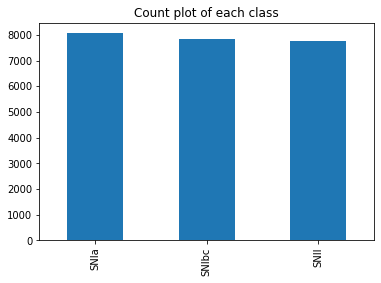

In [ ]:
ax = df_train.groupby('SNID').max().CLASS.value_counts().plot.bar()
ax.set_title('Count plot of each class')

In [ ]:
colors = {'u': 'b', 'g': 'g', 'r': 'r', 'i': 'orange', 'z': 'brown', 'Y': 'k'}


In [ ]:
a = df_train[df_train.SNID == str(87121171)]
a.FLUXCAL

92327    -9.141979
92328    -3.715305
92329    11.535588
92330    -6.346811
92331    -0.799646
           ...    
92403     4.076999
92404     1.727295
92405    30.887997
92406    11.747969
92407     0.397222
Name: FLUXCAL, Length: 81, dtype: float32

In [ ]:
def plot_lc(SNID, df, path=None):
    """
    Plots the lightcurves, generating a lightcurve (lc) for each band, but it shows
    all bands in one figure.
    """
    fig, ax = plt.subplots(figsize=(8,3))
    for idx, c in enumerate(colors.keys()):
      mask = (df.SNID == str(SNID)) & (df.BAND == c)
      if mask.sum() > 0:
        ax.errorbar(df.loc[mask].MJD, df.loc[mask].FLUXCAL,
                      yerr=df.loc[mask].FLUXCALERR, color=list(colors.values())[idx], fmt='o', ms=2, lw=0, elinewidth=1, label=c)
       
      # Agregue la PEAKMJD porque queria buscar alguna forma para encontrarlo 
      ax.axvline(x=df[df.SNID== str(SNID)].PEAKMJD.unique(), ls='--', color='r')

      
    ax.set_xlabel('mjd') # modified Julian date
    ax.set_ylabel('Flux')
    ax.legend()
    ax.set_title(str(SNID) + ' ' + df.loc[mask].iloc[0].CLASS)
    if path is not None: fig.savefig(path+'lc_'+SNID+'.png')

In [ ]:
# Obtaining the samples

np.random.seed(73)

snids = []  # In this array, the snid's of the objects will be stored.

for i in range(len(df_train.CLASS.unique())):
    snids.append(
        list(df_train.loc[df_train['CLASS'].isin([df_train.CLASS.unique()[i]])].sample(5).SNID))

snids = sum(snids, [])  # Transform list of lists into a list containing each snid

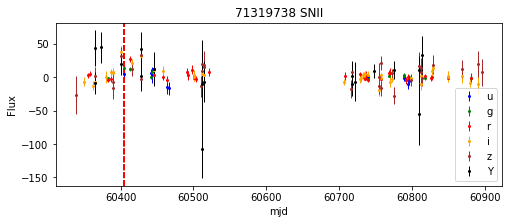

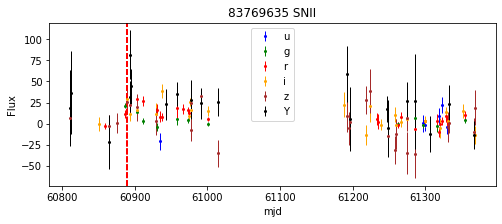

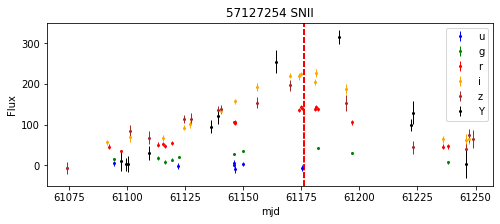

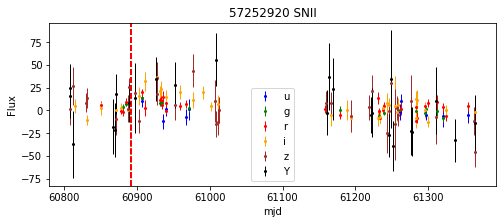

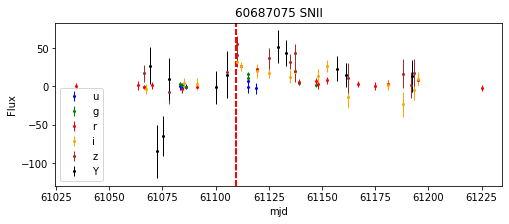

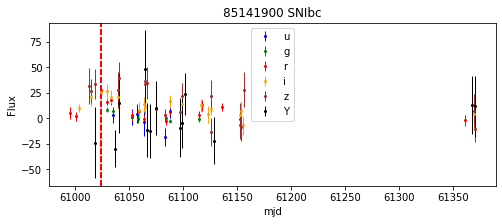

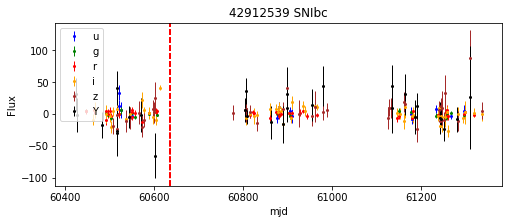

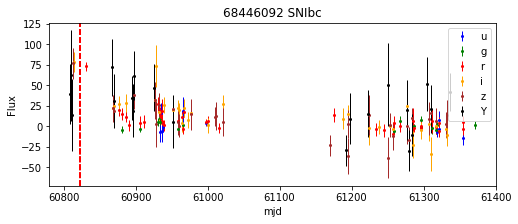

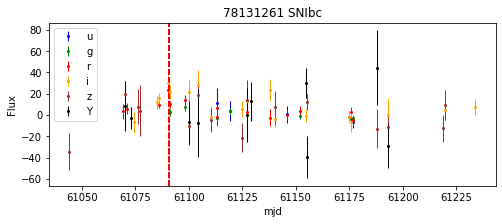

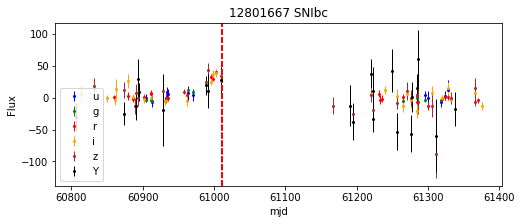

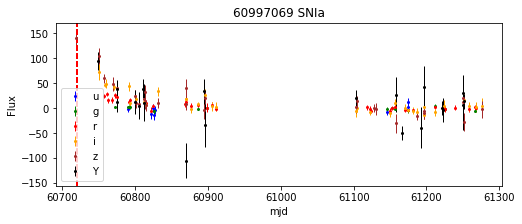

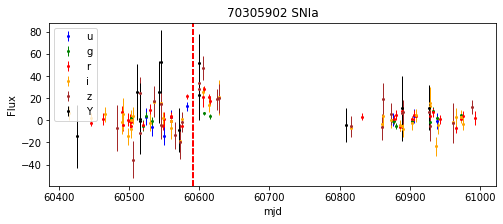

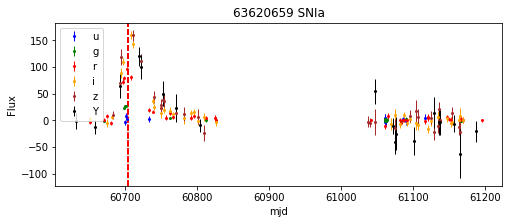

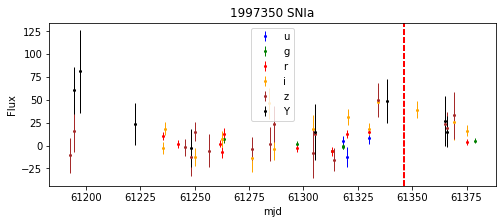

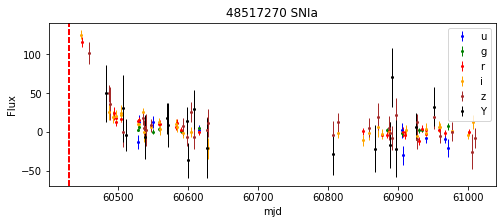

In [ ]:
for snid in snids:
    plot_lc(snid, df_train)
    
    plt.show()

In [ ]:
df_train.loc[df_train.SNID == '1723109'].HOSTGAL_MAG_i.unique()

array([999.], dtype=float32)

Reemplazo los valores negativos por el valor promedio de los flujos > 0 en cada banda.

In [ ]:
snids = df_train.SNID.unique()

In [ ]:
def reemplazo(SNID, df):
  for idx, c in enumerate(colors.keys()):
    mask = (df.SNID == str(SNID)) & (df.BAND == c)
    rt = df.loc[mask]

    f_mean = rt[rt.FLUXCAL>0].FLUXCAL.mean()

    df.loc[mask, 'FLUXCAL'] = np.where(df.loc[mask].FLUXCAL<0, 
                                             f_mean, df.loc[mask].FLUXCAL)
    return df

In [ ]:
np.max(df_train.FLUXCAL)

38258.547

Voy a definir training y test set antes de crear las imágenes para que el proceso no sea tan costoso. 

In [ ]:
new = df_train[['SNID', 'MJD','BAND', 'FLUXCAL', 'FLUXCALERR']]


In [ ]:
for snid in snids:
  reemplazo(snid, df_train)

KeyboardInterrupt: ignored

In [ ]:
new=df_train.copy()


In [ ]:
mask = (new.SNID == str(snids[190])) & (new.BAND == 'z')
rt = new.loc[mask]


In [ ]:
rt.FLUXCAL

22426     4.566526
22433   -23.372879
22435     9.807019
22437   -11.421865
22439   -12.707404
22448    10.342941
22451    20.055704
22456   -31.329628
22468    75.612122
22470    69.323830
22471    94.873535
22473    63.613255
22475    65.266075
22489    32.262131
22492    26.442610
22494    15.646214
22504     7.467861
22506    -4.254179
22508    -1.122820
22515   -21.494680
22517   -11.328855
22520   -30.259964
22523    22.120872
22529     7.763712
22531    26.189014
22532    20.695248
22540    12.619064
22550   -16.784792
22552    -3.393673
22554   -17.105772
22555    18.216362
22558    22.064995
22562    -6.453030
22573    -5.703614
22576     0.384661
22579     9.102341
22583   -14.912112
22586     8.026701
22594     2.566238
22599    -4.536789
22607    -3.902139
22609    -1.164264
Name: FLUXCAL, dtype: float32

In [ ]:
f_mean = rt[rt.FLUXCAL>0].FLUXCAL.mean()
new.loc[mask, 'FLUXCAL'] = np.where(new.loc[mask].FLUXCAL<0, 
                                             f_mean, new.loc[mask].FLUXCAL)

In [ ]:
new.loc[mask, 'FLUXCAL']

22426     4.566526
22433    26.876211
22435     9.807019
22437    26.876211
22439    26.876211
22448    10.342941
22451    20.055704
22456    26.876211
22468    75.612122
22470    69.323830
22471    94.873535
22473    63.613255
22475    65.266075
22489    32.262131
22492    26.442610
22494    15.646214
22504     7.467861
22506    26.876211
22508    26.876211
22515    26.876211
22517    26.876211
22520    26.876211
22523    22.120872
22529     7.763712
22531    26.189014
22532    20.695248
22540    12.619064
22550    26.876211
22552    26.876211
22554    26.876211
22555    18.216362
22558    22.064995
22562    26.876211
22573    26.876211
22576     0.384661
22579     9.102341
22583    26.876211
22586     8.026701
22594     2.566238
22599    26.876211
22607    26.876211
22609    26.876211
Name: FLUXCAL, dtype: float32

Text(0.5, 1.0, 'Histograma de Flujos')

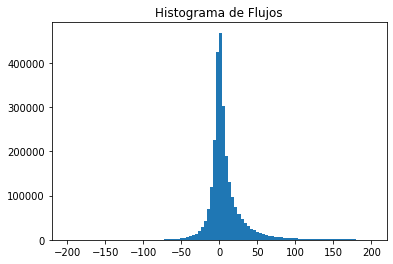

In [ ]:
# Histograma de flujos de todos los datos
counts, bins = np.histogram(df_train.FLUXCAL.to_numpy(), bins=100, range=(-200,200))
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de Flujos')

In [ ]:
"""
# Histograma de flujos de todos los datos
fig, (ax0, ax1, ax2, ax3)= plt.subplots(1,4, figsize=(20, 5))

counts, bins = np.histogram(df_train.FLUXCAL.to_numpy(), bins=100, range=(-200,200))
ax0.hist(bins[:-1], bins, weights=counts)
ax0.set_title('Histograma de Flujos ')

# Histograma SNIa
counts_IA, bins_IA = np.histogram(df_train[df_train.CLASS == 'SNIa'].FLUXCAL.to_numpy(), bins=100, range=(-200,200))
ax1.hist(bins_IA[:-1], bins_IA, weights=counts_IA)
ax1.set_title('Histograma de Flujos SNIa')

# Histograma SNIbc
counts_IBC, bins_IBC = np.histogram(df_train[df_train.CLASS == 'SNIbc'].FLUXCAL.to_numpy(), bins=100, range=(-200,200))
ax2.hist(bins_IBC[:-1], bins_IBC, weights=counts_IBC)
ax2.set_title('Histograma de Flujos SNIbc')

# Historgama SNII
counts_II, bins_II = np.histogram(df_train[df_train.CLASS == 'SNII'].FLUXCAL.to_numpy(), bins=100, range=(-200,200))
ax3.hist(bins_II[:-1], bins_II, weights=counts_II)
ax3.set_title('Histograma de Flujos SNII')
"""

"\n# Histograma de flujos de todos los datos\nfig, (ax0, ax1, ax2, ax3)= plt.subplots(1,4, figsize=(20, 5))\n\ncounts, bins = np.histogram(df_train.FLUXCAL.to_numpy(), bins=100, range=(-200,200))\nax0.hist(bins[:-1], bins, weights=counts)\nax0.set_title('Histograma de Flujos ')\n\n# Histograma SNIa\ncounts_IA, bins_IA = np.histogram(df_train[df_train.CLASS == 'SNIa'].FLUXCAL.to_numpy(), bins=100, range=(-200,200))\nax1.hist(bins_IA[:-1], bins_IA, weights=counts_IA)\nax1.set_title('Histograma de Flujos SNIa')\n\n# Histograma SNIbc\ncounts_IBC, bins_IBC = np.histogram(df_train[df_train.CLASS == 'SNIbc'].FLUXCAL.to_numpy(), bins=100, range=(-200,200))\nax2.hist(bins_IBC[:-1], bins_IBC, weights=counts_IBC)\nax2.set_title('Histograma de Flujos SNIbc')\n\n# Historgama SNII\ncounts_II, bins_II = np.histogram(df_train[df_train.CLASS == 'SNII'].FLUXCAL.to_numpy(), bins=100, range=(-200,200))\nax3.hist(bins_II[:-1], bins_II, weights=counts_II)\nax3.set_title('Histograma de Flujos SNII')\n"

In [ ]:
"""# Histograma de Errores
fig, (ax0, ax1, ax2, ax3)= plt.subplots(1,4, figsize=(20, 5))

counts_err, bins_err = np.histogram(df_train.FLUXCALERR.to_numpy(), bins=50, range=(0, 100))
ax0.hist(bins_err[:-1], bins_err, weights=counts_err)
ax0.set_title('Histograma de Errores de Flujos')

# Histograma SNIa
counts_IA_err, bins_IA_err = np.histogram(df_train[df_train.CLASS == 'SNIa'].FLUXCALERR.to_numpy(), bins=50, range=(0,100))
ax1.hist(bins_IA_err[:-1], bins_IA_err, weights=counts_IA_err)
ax1.set_title('Histograma de Errores de Flujos SNIa')

# Histograma SNIbc
counts_IBC_err, bins_IBC_err = np.histogram(df_train[df_train.CLASS == 'SNIbc'].FLUXCALERR.to_numpy(), bins=50, range=(0,100))
ax2.hist(bins_IBC_err[:-1], bins_IBC_err, weights=counts_IBC_err)
ax2.set_title('Histograma de Errores Flujos SNIbc')

# Historgama SNII
counts_II_err, bins_II_err = np.histogram(df_train[df_train.CLASS == 'SNII'].FLUXCALERR.to_numpy(), bins=50, range=(0,100))
ax3.hist(bins_II_err[:-1], bins_II_err, weights=counts_II_err)
ax3.set_title('Histograma de Errores SNII')
"""

"# Histograma de Errores\nfig, (ax0, ax1, ax2, ax3)= plt.subplots(1,4, figsize=(20, 5))\n\ncounts_err, bins_err = np.histogram(df_train.FLUXCALERR.to_numpy(), bins=50, range=(0, 100))\nax0.hist(bins_err[:-1], bins_err, weights=counts_err)\nax0.set_title('Histograma de Errores de Flujos')\n\n# Histograma SNIa\ncounts_IA_err, bins_IA_err = np.histogram(df_train[df_train.CLASS == 'SNIa'].FLUXCALERR.to_numpy(), bins=50, range=(0,100))\nax1.hist(bins_IA_err[:-1], bins_IA_err, weights=counts_IA_err)\nax1.set_title('Histograma de Errores de Flujos SNIa')\n\n# Histograma SNIbc\ncounts_IBC_err, bins_IBC_err = np.histogram(df_train[df_train.CLASS == 'SNIbc'].FLUXCALERR.to_numpy(), bins=50, range=(0,100))\nax2.hist(bins_IBC_err[:-1], bins_IBC_err, weights=counts_IBC_err)\nax2.set_title('Histograma de Errores Flujos SNIbc')\n\n# Historgama SNII\ncounts_II_err, bins_II_err = np.histogram(df_train[df_train.CLASS == 'SNII'].FLUXCALERR.to_numpy(), bins=50, range=(0,100))\nax3.hist(bins_II_err[:-1], bi

In [ ]:
# df_train.insert(74, 'SNR', np.fabs(df_train.FLUXCAL/df_train.FLUXCALERR))

In [ ]:
"""
# Histograma de SNR
fig, (ax0, ax1, ax2, ax3)= plt.subplots(1,4, figsize=(20, 5))

counts_snr, bins_snr = np.histogram(df_train.SNR, bins=50, range=(0, 100))
ax0.hist(bins_snr[:-1], bins_snr, weights=counts_snr)
ax0.set_title('Histograma de SNR')

# Histograma SNIa
a = df_train[df_train.CLASS == 'SNIa']
counts_IA_snr, bins_IA_snr = np.histogram(a.SNR, bins=50, range=(0,100))
ax1.hist(bins_IA_snr[:-1], bins_IA_snr, weights=counts_IA_snr)
ax1.set_title('Histograma de SNR SNIa')

# Histograma SNIbc

bc = df_train[df_train.CLASS == 'SNIbc']
counts_IBC_snr, bins_IBC_snr = np.histogram(bc.SNR, bins=50, range=(0,100))
ax2.hist(bins_IBC_snr[:-1], bins_IBC_snr, weights=counts_IBC_snr)
ax2.set_title('Histograma de SNR SNIbc')

# Historgama SNII￼
snii = df_train[df_train.CLASS == 'SNII']
counts_II_snr, bins_II_snr = np.histogram(snii.SNR, bins=50, range=(0,100))
ax3.hist(bins_II_snr[:-1], bins_II_snr, weights=counts_II_snr)
ax3.set_title('Histograma de SNR SNII')
"""

"\n# Histograma de SNR\nfig, (ax0, ax1, ax2, ax3)= plt.subplots(1,4, figsize=(20, 5))\n\ncounts_snr, bins_snr = np.histogram(df_train.SNR, bins=50, range=(0, 100))\nax0.hist(bins_snr[:-1], bins_snr, weights=counts_snr)\nax0.set_title('Histograma de SNR')\n\n# Histograma SNIa\na = df_train[df_train.CLASS == 'SNIa']\ncounts_IA_snr, bins_IA_snr = np.histogram(a.SNR, bins=50, range=(0,100))\nax1.hist(bins_IA_snr[:-1], bins_IA_snr, weights=counts_IA_snr)\nax1.set_title('Histograma de SNR SNIa')\n\n# Histograma SNIbc\n\nbc = df_train[df_train.CLASS == 'SNIbc']\ncounts_IBC_snr, bins_IBC_snr = np.histogram(bc.SNR, bins=50, range=(0,100))\nax2.hist(bins_IBC_snr[:-1], bins_IBC_snr, weights=counts_IBC_snr)\nax2.set_title('Histograma de SNR SNIbc')\n\n# Historgama SNII\nsnii = df_train[df_train.CLASS == 'SNII']\ncounts_II_snr, bins_II_snr = np.histogram(snii.SNR, bins=50, range=(0,100))\nax3.hist(bins_II_snr[:-1], bins_II_snr, weights=counts_II_snr)\nax3.set_title('Histograma de SNR SNII')\n"

In [ ]:
# Se podrían dejar solo los objetos con flujo entre -50 y 50 (bin)
# Eliminar los objetos con error mayor a 40 (bin)
# (igual se podría cambiar el valor dependiendo de los valores de flujo max que definamos)
# Ver cómo cambia el SNR -> SNR~0 malito, lo ideal es tener SNR alto

In [ ]:
"""
# Filtros (Colores de las galaxias)
df_train.insert(40, 'HOSTGAL_g-r', df_train.HOSTGAL_MAG_g - df_train.HOSTGAL_MAG_r)
df_train.insert(41, 'HOSTGAL_u-r', df_train.HOSTGAL_MAG_u - df_train.HOSTGAL_MAG_r)
df_train.insert(42, 'HOSTGAL_i-z', df_train.HOSTGAL_MAG_i - df_train.HOSTGAL_MAG_z)

df_train.insert(73, 'HOSTGAL2_g-r', df_train.HOSTGAL2_MAG_g - df_train.HOSTGAL2_MAG_r)
df_train.insert(74, 'HOSTGAL2_u-r', df_train.HOSTGAL2_MAG_u - df_train.HOSTGAL2_MAG_r)
df_train.insert(75, 'HOSTGAL2_i-z', df_train.HOSTGAL2_MAG_i - df_train.HOSTGAL2_MAG_z)
# No entrega info sobre si una galaxia es más roja o no, sino de la magnitud relativa g-r
"""

"\n# Filtros (Colores de las galaxias)\ndf_train.insert(40, 'HOSTGAL_g-r', df_train.HOSTGAL_MAG_g - df_train.HOSTGAL_MAG_r)\ndf_train.insert(41, 'HOSTGAL_u-r', df_train.HOSTGAL_MAG_u - df_train.HOSTGAL_MAG_r)\ndf_train.insert(42, 'HOSTGAL_i-z', df_train.HOSTGAL_MAG_i - df_train.HOSTGAL_MAG_z)\n\ndf_train.insert(73, 'HOSTGAL2_g-r', df_train.HOSTGAL2_MAG_g - df_train.HOSTGAL2_MAG_r)\ndf_train.insert(74, 'HOSTGAL2_u-r', df_train.HOSTGAL2_MAG_u - df_train.HOSTGAL2_MAG_r)\ndf_train.insert(75, 'HOSTGAL2_i-z', df_train.HOSTGAL2_MAG_i - df_train.HOSTGAL2_MAG_z)\n# No entrega info sobre si una galaxia es más roja o no, sino de la magnitud relativa g-r\n"

### Features

Based on [Neira M. et. al. 2020](https://iopscience.iop.org/article/10.3847/1538-4365/aba267/pdf), some features based on magnitude are:
* **amp**: the difference between the maximum and minimum magnitudes
* **max_slope**: the maximum absolute slope between two consecutive observations.
* **mad**: the median of the difference between magnitudes and the median magnitude.
* **mbrp**: the ratio (percentage in the paper) of points within 10% of the median magnitude. 
* **pst**: the percentage of all pairs of consecutive magnitude measurements that have a positive slope.
* **pst_last30**: the percentage of the last 30 pairs of consecutive magnitudes that have a positive slope, minus percentage of the last 30 pairs of consecutive magnitudes with a negative slope.
* **rcb**: the percentage of data points whose magnitude is below 1.5 mag of the median.
* **ls**: the period of the peak frequency of the Lomb–Scargle periodogram (Scargle 1982).

In [ ]:
"""
def mag_features(SNID, df):
    # Needs to be modified. Eventually should add columns to dataframe with the features
    
    mask = (df.SNID == str(SNID))
    amp = df.loc[mask].FLUXCAL.max() - df.loc[mask].FLUXCAL.min()

    median_flux = df.loc[mask].FLUXCAL.median()
    over = (df.loc[mask].FLUXCAL / median_flux < 1.1)
    under = (df.loc[mask].FLUXCAL / median_flux > .9)
    mbrp = len(df.loc[mask].loc[(over) & (under)]) / len(df.loc[mask])
    
    #rcb = len(df.loc[mask].loc[df.loc[mask].FLUXCAL > 1.5 * median_flux]) / len(df.loc[mask])
    return [amp, mbrp] #, rcb]

mag_features(27528421, df_train)

"""

'\ndef mag_features(SNID, df):\n    # Needs to be modified. Eventually should add columns to dataframe with the features\n    \n    mask = (df.SNID == str(SNID))\n    amp = df.loc[mask].FLUXCAL.max() - df.loc[mask].FLUXCAL.min()\n\n    median_flux = df.loc[mask].FLUXCAL.median()\n    over = (df.loc[mask].FLUXCAL / median_flux < 1.1)\n    under = (df.loc[mask].FLUXCAL / median_flux > .9)\n    mbrp = len(df.loc[mask].loc[(over) & (under)]) / len(df.loc[mask])\n    \n    #rcb = len(df.loc[mask].loc[df.loc[mask].FLUXCAL > 1.5 * median_flux]) / len(df.loc[mask])\n    return [amp, mbrp] #, rcb]\n\nmag_features(27528421, df_train)\n\n'

In [ ]:
df_train[['FLUXCAL', 'MJD', 'FLUXCALERR']]

,FLUXCAL,MJD,FLUXCALERR
0,-6.731427,60871.3943,7.358455
1,-8.563615,60871.4132,8.348427
2,2.500511,60877.4268,4.012604
3,1.031235,60881.4389,3.955907
4,4.555480,60884.4122,4.583658
...,...,...,...
158400,17.334860,61157.0053,9.278357
158401,8.248342,61157.0476,14.486826
158402,-37.551552,61157.0640,25.863119
158403,-22.009718,61160.0229,19.373653


In [ ]:
NJ

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df_train.BAND = encoder.fit_transform(df_train.BAND)

color = np.sort(df_train.BAND.unique())
color

In [ ]:
import random

In [ ]:
a = df_train[df_train.CLASS == 'SNIa']
bc = df_train[df_train.CLASS == 'SNIbc']
snii = df_train[df_train.CLASS == 'SNII']


In [ ]:
a_snids = len(a.SNID.unique())
b_snids = len(bc.SNID.unique())
ii_snids = len(snii.SNID.unique())
tot = a_snids + b_snids + ii_snids

k_a = int(np.round((a_snids/tot), 2) * 1000)
k_b = int(np.round((b_snids/tot), 2) * 1000)
k_ii = (np.round((ii_snids/tot), 2) * 1000)

print('% de cada clase')
print('a: ', np.round((a_snids/tot), 3))
print('b: ', np.round((b_snids/tot), 3))
print('ii: ', np.round((ii_snids/tot), 3))

In [ ]:
np.random.seed(2342)

In [ ]:
a_snids = a.SNID.unique()
r_snids_a = np.array(random.choices(a_snids, k=k_a))

X_a = np.zeros((len(r_snids_a), 6, 600))

for i in range(len(r_snids_a)):
  for c in color:
    mask = (df_train.SNID == r_snids_a[i]) & (df_train.BAND == c)
    data = df_train.loc[mask][['MJD', 'FLUXCAL']].to_numpy()
    for h in range(len(data)):
      if 60650 <= data[h][0] < 61250:
        ind = int(data[h][0] - 60650)
        X_a[i][c][ind] = data[h][1]

# Plot 5 imag de SNIa

fig, ax = plt.subplots(5,figsize=(30,6))
ax[0].imshow(X_a[0], vmin=0)
ax[1].imshow(X_a[1], vmin=0)
ax[2].imshow(X_a[2], vmin=0)
ax[3].imshow(X_a[3], vmin=0)
ax[4].imshow(X_a[4], vmin=0)

print(i)

In [ ]:
X_a_err = np.zeros((len(r_snids_a), 6, 600))
for i in range(len(r_snids_a)):
  for c in color:
    mask = (df_train.SNID == r_snids_a[i]) & (df_train.BAND == c)
    data = df_train.loc[mask][['MJD', 'FLUXCALERR']].to_numpy()
    for h in range(len(data)):
      if 60650 <= data[h][0] < 61250:
        ind = int(data[h][0] - 60650)
        X_a_err[i][c][ind] = data[h][1]

# Plot 5 imag de SNII (FLUXCALERR)

fig, ax = plt.subplots(5,figsize=(30,6))
ax[0].imshow(X_a_err[0], vmin=0)
ax[1].imshow(X_a_err[1], vmin=0)
ax[2].imshow(X_a_err[2], vmin=0)
ax[3].imshow(X_a_err[3], vmin=0)
ax[4].imshow(X_a_err[4], vmin=0)



In [ ]:
np.random.seed(2342)
bc_snids = bc.SNID.unique()
r_snids_bc = np.array(random.choices(bc_snids, k=k_b))

X_bc = np.zeros((len(r_snids_bc), 6, 600))
for i in range(len(r_snids_bc)):
  for c in color:
    mask = (df_train.SNID == r_snids_bc[i]) & (df_train.BAND == c)
    data = df_train.loc[mask][['MJD', 'FLUXCAL']].to_numpy()
    for h in range(len(data)):
      if 60650 <= data[h][0] < 61250:
        ind = int(data[h][0] - 60650)
        X_bc[i][c][ind] = data[h][1]
        
# Plot 5 imag de SNIbc

fig, ax = plt.subplots(5,figsize=(30,6))
ax[0].imshow(X_bc[0], vmin=0)
ax[1].imshow(X_bc[1], vmin=0)
ax[2].imshow(X_bc[2], vmin=0)
ax[3].imshow(X_bc[3], vmin=0)
ax[4].imshow(X_bc[4], vmin=0)



In [ ]:
X_bc_err = np.zeros((len(r_snids_bc), 6, 600))
for i in range(len(r_snids_bc)):
  for c in color:
    mask = (df_train.SNID == r_snids_bc[i]) & (df_train.BAND == c)  # <- Ojo: hay que cambiar r_snids_a por r_snids_bc
    data = df_train.loc[mask][['MJD', 'FLUXCALERR']].to_numpy()
    for h in range(len(data)):
      if 60650 <= data[h][0] < 61250:
        ind = int(data[h][0] - 60650)
        X_bc_err[i][c][ind] = data[h][1]

# Plot 5 imag de SNIbc (FLUXCALERR)

fig, ax = plt.subplots(5,figsize=(30,6))
ax[0].imshow(X_bc_err[0], vmin=0)
ax[1].imshow(X_bc_err[1], vmin=0)
ax[2].imshow(X_bc_err[2], vmin=0)
ax[3].imshow(X_bc_err[3], vmin=0)
ax[4].imshow(X_bc_err[4], vmin=0)

print(i)

In [ ]:
ii_snids = snii.SNID.unique()
r_snids_ii = np.array(random.choices(ii_snids, k=k_ii))

X_ii = np.zeros((len(r_snids_ii), 6, 600))
for i in range(len(r_snids_ii)):
  for c in color:
    mask = (df_train.SNID == r_snids_ii[i]) & (df_train.BAND == c)
    data = df_train.loc[mask][['MJD', 'FLUXCAL']].to_numpy()
    for h in range(len(data)):
      if 60650 <= data[h][0] < 61250:
        ind = int(data[h][0] - 60650)
        X_ii[i][c][ind] = data[h][1]

# Plot 5 imag de SNII

fig, ax = plt.subplots(5,figsize=(30,6))
ax[0].imshow(X_ii[0], vmin=0)
ax[1].imshow(X_ii[1], vmin=0)
ax[2].imshow(X_ii[2], vmin=0)
ax[3].imshow(X_ii[3], vmin=0)
ax[4].imshow(X_ii[4], vmin=0)

In [ ]:
X_ii_err = np.zeros((len(r_snids_ii), 6, 600))
for i in range(len(r_snids_ii)):
  for c in color:
    mask = (df_train.SNID == r_snids_ii[i]) & (df_train.BAND == c)
    data = df_train.loc[mask][['MJD', 'FLUXCALERR']].to_numpy()
    for h in range(len(data)):
      if 60650 <= data[h][0] < 61250:
        ind = int(data[h][0] - 60650)
        X_ii_err[i][c][ind] = data[h][1]

# Plot 5 imag de SNII (FLUXCALERR)

fig, ax = plt.subplots(5,figsize=(30,6))
ax[0].imshow(X_ii_err[0], vmin=0)
ax[1].imshow(X_ii_err[1], vmin=0)
ax[2].imshow(X_ii_err[2], vmin=0)
ax[3].imshow(X_ii_err[3], vmin=0)
ax[4].imshow(X_ii_err[4], vmin=0)



In [ ]:
# Histograma de flujos de todos los datos
plt.figure(figsize=(18,6))
counts, bins = np.histogram(df_train.MJD.to_numpy(), bins=300)
plt.hist(bins[:-1], bins, weights=counts)
plt.title('Histograma de Flujos')